In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import os
from google.cloud import bigquery

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"
client = bigquery.Client()


In [3]:
attributes = {
    "U10": "u10",
    "V10": "v10",
    "2m Dewpoint Temperature": "d2m",
    "2m Temperature": "t2m",
    "Mean Sea Level Pressure": "msl",
    "Sea Surface Temperature": "sst",
    "Surface Pressure": "sp",
    "Total Cloud Cover": "tcc",
    "Total Column Cloud Ice Water": "tciw",
    "Total Column Liquid Water": "tclw"
}

df = {}
for attribute in attributes.values():
    QUERY = f'''
        SELECT
            {attribute}
        FROM
            `strong-ward-437213-j6.bigdata_20241.other_data_2024_main`
        WHERE
            valid_time >= '2024-09-07 00:00:00 UTC'
            AND valid_time <= '2024-09-07 23:00:00 UTC'
        ORDER BY
            valid_time, latitude DESC, longitude
    '''
    
    # Execute the query and get results
    query_job = client.query(QUERY)
    rows = query_job.result()

    # Convert results to a numpy array
    data = [row[0] for row in rows]

    # Process data and create a dictionary of 3D arrays for each attribute
    df[attribute] =  np.reshape(data, (24, 65, 41)) 

In [4]:

def distance_matrix(lons,lats):
    '''Calculates the distances (in km) between any two cities based on the formulas
    c = sin(lati1)*sin(lati2)+cos(longi1-longi2)*cos(lati1)*cos(lati2)
    d = EARTH_RADIUS*Arccos(c)
    where EARTH_RADIUS is in km and the angles are in radians.
    Source: http://mathforum.org/library/drmath/view/54680.html
    This function returns the matrix.'''

    EARTH_RADIUS = 6378.1
    X = len(lons)
    Y = len(lats)
    assert X == Y, 'lons and lats must have same number of elements'

    d = np.zeros((X,X))

    #Populate the matrix.
    for i2 in range(len(lons)):
        lati2 = lats[i2]
        loni2 = lons[i2]
        c = np.sin(np.radians(lats)) * np.sin(np.radians(lati2)) + \
            np.cos(np.radians(lons-loni2)) * \
            np.cos(np.radians(lats)) * np.cos(np.radians(lati2))
        d[c<1,i2] = EARTH_RADIUS * np.arccos(c[c<1])

    return d

def diameter(area):
    r = np.sqrt((area/np.pi))
    return (r*2)

def major_ratio(area, ratio):
    # given the area and ratio of minor to major axis of an ellipse, returns the length of the major axis
    maj = np.sqrt(area/(np.pi*ratio))
    return maj 

def major_ecc(area, ecc):
    # given the area and eccentricity of an ellipse, returns the length of the major axis    
    denom = np.pi*np.sqrt(1-(ecc**2))
    maj = np.sqrt(area/denom)
    return maj

def ecc(ratio):
    #given ratio of a/b, calculates eccentricity of ellipse
    e = (ratio)*(np.sqrt((ratio**-2)-1))
    return e

def nanmean(array, axis=None):
    return np.mean(np.ma.masked_array(array, np.isnan(array)), axis)

def len_deg_lon(lat):
    '''
    Returns the length of one degree of longitude (at latitude
    specified) in km.
    '''

    R = 6371. # Radius of Earth [km]

    return (np.pi/180.) * R * np.cos( lat * np.pi/180. )

def spatial_filter(msl, lon, lat, res, cut_lon, cut_lat):
    '''
    Performs a spatial filter, removing all features with
    wavelenth scales larger than cut_lon in longitude and
    cut_lat in latitude from msl (defined in grid given
    by lon and lat).  msl has spatial resolution of res
    and land identified by np.nan's
    '''

    msl_filt = np.zeros(msl.shape)

    # see Chelton et al, Prog. Ocean., 2011 for explanation of factor of 1/5
    sig_lon = (cut_lon/5.) / res
    sig_lat = (cut_lat/5.) / res

    land = np.isnan(msl)
    msl[land] = nanmean(msl)

    msl_filt =  ndimage.gaussian_filter(msl, [sig_lat, sig_lon])

    msl_filt[land] = np.nan

    return msl_filt


def detect_storms(msl, wind_speed, lon, lat, res, order, Npix_min, Npix_max, rel_amp_thresh, d_thresh, cyc, cut_lon, cut_lat, globe=False):
    '''
    Detect storms present in msl which satisfy the criteria.
    Algorithm is an adaptation of an eddy detection algorithm,
    outlined in Chelton et al., Prog. ocean., 2011, App. B.2,
    with modifications needed for storm detection.

    msl is a 2D array specified on grid defined by lat and lon.

    res is the horizontal grid resolution in degrees of msl

    Npix_min is the minimum number of pixels within which an
    extremum of msl must lie (recommended: 9).

    cyc = 'cyclonic' or 'anticyclonic' specifies type of system
    to be detected (cyclonic storm or high-pressure systems)

    globe is an option to detect storms on a globe, i.e. with periodic
    boundaries in the West/East. Note that if using this option the 
    supplied longitudes must be positive only (i.e. 0..360 not -180..+180).

    Function outputs lon, lat coordinates of detected storms
    '''

    len_deg_lat = 111.325 # length of 1 degree of latitude [km]

    msl = spatial_filter(msl, lon, lat, res, cut_lon, cut_lat)
    # Need to repeat global msl to the West and East to properly detect around the edge
    if globe:
        dl = 20. # Degrees longitude to repeat on East and West of edge
        iEast = np.where(lon >= 360. - dl)[0][0]
        iWest = np.where(lon <= dl)[0][-1]
        lon = np.append(lon[iEast:]-360, np.append(lon, lon[:iWest]+360))
        msl = np.append(msl[:,iEast:], np.append(msl, msl[:,:iWest], axis=1), axis=1)

    llon, llat = np.meshgrid(lon, lat)

    lon_storms = np.array([])
    lat_storms = np.array([])
    amp_storms = np.array([])
    area_storms = np.array([])
    max_wind_speeds = np.array([])
    regions_storm = []
    

    # ssh_crits is an array of ssh levels over which to perform storm detection loop
    # ssh_crits increasing for 'cyclonic', decreasing for 'anticyclonic'
    ssh_crits = np.linspace(np.nanmin(msl), np.nanmax(msl), 200)
    ssh_crits = np.array([100000])
    if order == 'topdown':
        ssh_crits = np.flipud(ssh_crits)

    # loop over ssh_crits and remove interior pixels of detected storms from subsequent loop steps
    for ssh_crit in ssh_crits:
 
    # 1. Find all regions with eta greater (less than) than ssh_crit for anticyclonic (cyclonic) storms (Chelton et al. 2011, App. B.2, criterion 1)
        if cyc == 'anticyclonic':
            regions, nregions = ndimage.label( (msl>ssh_crit).astype(int) )
        elif cyc == 'cyclonic':
            regions, nregions = ndimage.label( (msl<ssh_crit).astype(int) )

        for iregion in range(nregions):
 
    # 2. Calculate number of pixels comprising detected region, reject if not within >= Npix_min
            region = (regions==iregion+1).astype(int)
            region_Npix = region.sum()
            storm_area_within_limits = ((region_Npix >= Npix_min) * (region_Npix <= Npix_max))
 
    # 3. Detect presence of local maximum (minimum) for anticylones (cyclones), reject if non-existents
            interior = ndimage.binary_erosion(region)
            #exterior = region.astype(bool) - interior
            exterior = np.logical_xor(region.astype(bool), interior)
            if interior.sum() == 0:
                continue
            if cyc == 'anticyclonic':
                has_internal_ext = msl[interior].max() > msl[exterior].max()
            elif cyc == 'cyclonic':
                has_internal_ext = msl[interior].min() < msl[exterior].min()
 
    # 4. Find amplitude of region, reject if < amp_thresh
            if cyc == 'anticyclonic':
                amp_abs = msl[interior].max()
                amp = amp_abs - msl[exterior].mean()
            elif cyc == 'cyclonic':
                amp_abs = msl[interior].min()
                amp = msl[exterior].mean() - amp_abs
            #amp_thresh = np.abs(np.diff(ssh_crits)[0])
            is_tall_storm = amp >= rel_amp_thresh

    # 5. Find maximum linear dimension of region, reject if < d_thresh
            lon_ext = llon[exterior]
            lat_ext = llat[exterior]
            d = distance_matrix(lon_ext, lat_ext)
            is_small_storm = d.max() < d_thresh
    

    # Quit loop if these are not satisfied
            if np.logical_not(storm_area_within_limits * has_internal_ext * is_tall_storm * is_small_storm):
                continue
 
    # Detected storms:
            if (storm_area_within_limits * has_internal_ext * is_tall_storm * is_small_storm):
                # find centre of mass of storm
                storm_object_with_mass = msl * region
                storm_object_with_mass[np.isnan(storm_object_with_mass)] = 0
                min_pressure_pos = np.unravel_index(np.argmin(msl), msl.shape)
    
                # Chuyển đổi chỉ số vị trí (min_pressure_pos) thành tọa độ kinh độ và vĩ độ
                j_min, i_min = min_pressure_pos
                lon_cen = np.interp(i_min, range(0,len(lon)), lon)
                lat_cen = np.interp(j_min, range(0,len(lat)), lat)
                # Remove storms detected outside global domain (lon < 0, > 360)
                #if globe * (lon_cen >= 0.) * (lon_cen <= 360.):
                
                # Save storm
                lon_storms = np.append(lon_storms, lon_cen)
                lat_storms = np.append(lat_storms, lat_cen)
                
                # assign (and calculated) amplitude, area, and scale of storms
                amp_storms = np.append(amp_storms, amp_abs)
                area = region_Npix * res**2 * len_deg_lat * len_deg_lon(lat_cen) # [km**2]
                area_storms = np.append(area_storms, area)                
                # remove its interior pixels from further storm detection
                storm_mask = np.ones(msl.shape)
                storm_mask[interior.astype(int)==1] = np.nan
                storm_mask = msl * storm_mask
                region_storm = np.isnan(storm_mask).astype(int)
                regions_storm.append(region_storm)
                max_wind_speed = (wind_speed*region_storm).max()
                max_wind_speeds = np.append(max_wind_speeds, max_wind_speed)

    return lon_storms, lat_storms, amp_storms, max_wind_speeds, area_storms, regions_storm, 


In [5]:
msl = df["msl"]
lon = np.arange(102, 112.25, 0.25)
lat = np.arange(24, 7.75,-0.25)
u10 = df["u10"]
v10 = df["v10"]
wind_speed = np.sqrt(u10*u10+v10*v10)
res = 0.25 
order = 'topdown' 
Npix_min = 9
Npix_max = 6000  
rel_amp_thresh = 100  
d_thresh = 2500  
cyc = 'cyclonic'  
cut_lon = 1  #
cut_lat = 1  
globe = False  

lon_storms, lat_storms, amp_storms, wind_spedds, area_storms, regions = detect_storms(
    msl[0, :, :], wind_speed[0, :, :], lon, lat, res, order, Npix_min, Npix_max, rel_amp_thresh, 
    d_thresh, cyc, cut_lon, cut_lat, globe
)

In [6]:
lon_storms, lat_storms, amp_storms, wind_spedds, area_storms, regions


(array([108.25]),
 array([20.5]),
 array([97577.12187712]),
 array([25.74671071]),
 array([379006.80564999]),
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])])

In [7]:
speed = wind_speed[0]*regions[0]
speed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

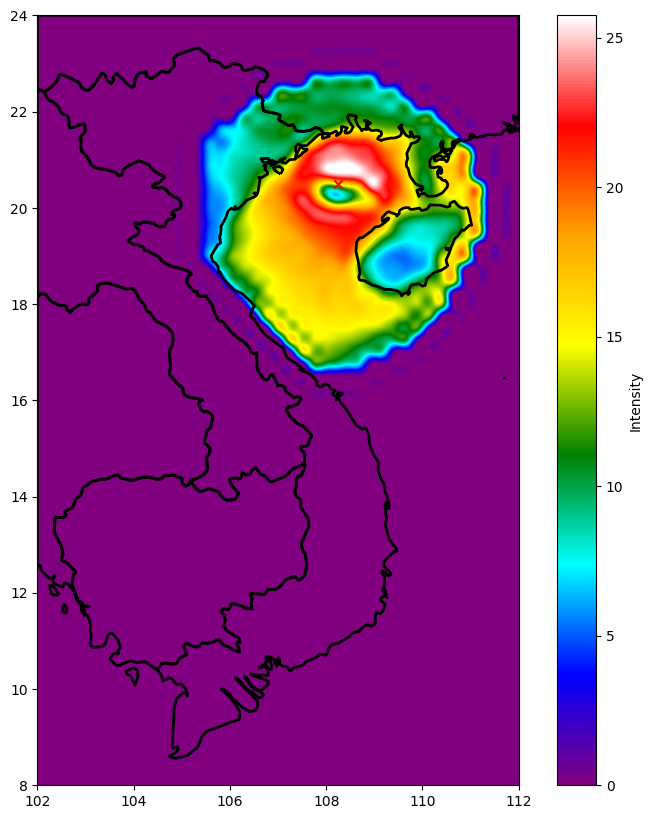

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Đọc file shapefile
shape = gpd.read_file('world-administrative-boundaries')

# Kiểm tra và chuyển đổi hệ tọa độ về WGS84 nếu cần thiết
if shape.crs != "EPSG:4326":
    shape = shape.to_crs("EPSG:4326")

# Tạo bounding box cho vùng cần cắt
bbox = box(102, 8, 112, 24)

# Cắt bản đồ theo bounding box
cropped_shape = shape.clip(bbox)

fig, ax = plt.subplots(figsize=(10, 10))

colors = ["purple", "blue", "cyan", "green", "yellow", "orange", "red", "white"]
custom_cmap = LinearSegmentedColormap.from_list("custom_purple_red", colors)
# Vẽ bản đồ đã cắt
cropped_shape.boundary.plot(ax=ax, color='black', linewidth=2)

# Vẽ heatmap
plt.imshow(speed[::-1], cmap=custom_cmap, interpolation='lanczos', extent=[102, 112, 8, 24], alpha=1.0, origin='lower')

# Thêm colorbar
plt.colorbar(label='Intensity')
ax.scatter(lon_storms, lat_storms, color='red', marker='x', label='Storm Centers')

# Hiển thị bản đồ
plt.show()

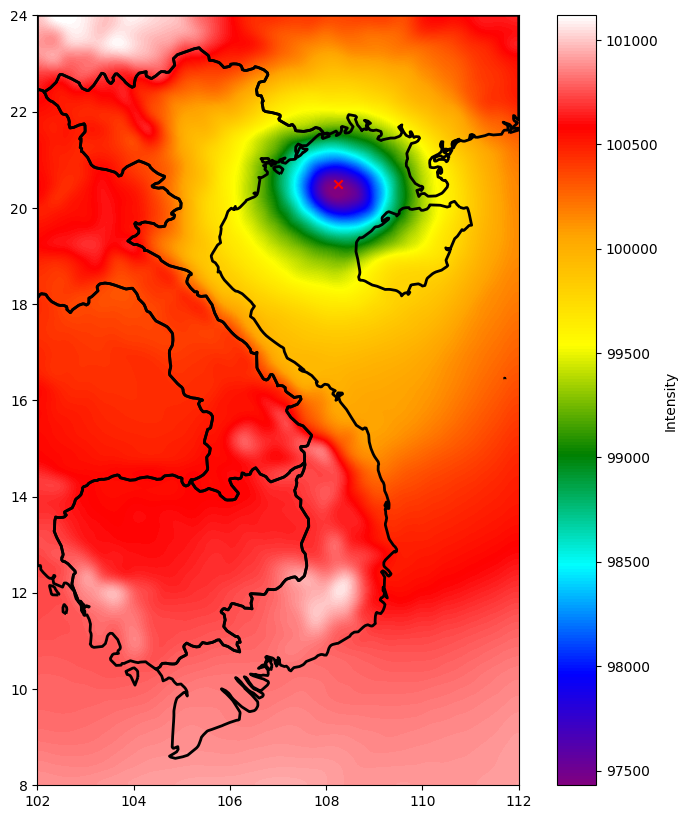

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = ["purple", "blue", "cyan", "green", "yellow", "orange", "red", "white"]
custom_cmap = LinearSegmentedColormap.from_list("custom_purple_red", colors)
# Vẽ bản đồ đã cắt
cropped_shape.boundary.plot(ax=ax, color='black', linewidth=2)

# Vẽ heatmap
plt.imshow(msl[0][::-1], cmap=custom_cmap, interpolation='lanczos', extent=[102, 112, 8, 24], alpha=1.0, origin='lower')

# Thêm colorbar
plt.colorbar(label='Intensity')
ax.scatter(lon_storms, lat_storms, color='red', marker='x', label='Storm Centers')

# Hiển thị bản đồ
plt.show()